# County-Level Analysis of Educational and Health Correlations in Arizona

### Authors: Pedro Alan Leal & Sean Michael Murray

## Summary

This project explores how education and health are connected at the county level across all Arizona counties.  
We wanted to understand whether places with stronger educational systems also show better health outcomes, and how different types of schools (like public, charter, or colleges) relate to specific health measures.

We used data from 2020 to start — the most recent full year available — which also gives us insight into these relationships during the COVID-19 pandemic. Our data came from health rankings, school locations, and county population numbers. We then expanded and used predicted data per county taken from az.gov to compare to the data up to our current year.

We calculated how many schools of each type exist per 10,000 residents in each county to fairly compare counties of different sizes. Then, we looked at how those numbers relate to a wide range of health outcomes, like premature death rates or drug overdose mortality, using scatter plots and mathematical models.

Our goal was to identify patterns and correlations that might help guide future decisions in public health and education. For example, if certain types of schools are strongly linked with better health outcomes, that could be useful information for policymakers.

Throughout this notebook, we will walk through our data sources, methods, results, and key insights.


## Libaries needed

These libraries handle data manipulation, visualization, and mapping. openpyxl helps work with Excel files, pandas makes data analysis easy, numpy supports numerical calculations, matplotlib is used to create visualizations, and folium allows us to build interactive maps. These libraries are essential for processing and presenting our data effectively.

In [ ]:
pip install openpyxl pandas numpy matplotlib folium plotly

## Imports and drive mount for colab

Importing essential tools for the project and mounting to a Google drive in order to access the project files directly in Colab.

In [1]:
import pandas as pd
import os
import re
import requests
import json
from datetime import datetime
from google.colab import drive
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import glob
import numpy as np
import folium
from folium.plugins import HeatMap
from IPython.display import HTML, display

drive.mount('/content/drive')

# Path to point to project folder
base_path = "/content/drive/MyDrive/APCV361_Group_Project_Shared_Folder"

Mounted at /content/drive


# Arizona County Health Data Processor

This script **automatically processes annual Arizona County Health Rankings for Excel files from (2020–2024)** by extracting each sheet, cleaning the sheet names, and saving them as organized CSV files. It ensures that the data is ready for analysis, mapping, or reporting across multiple years.

### What it does  

-  Reads all Excel files for each year from 2020–2024  
- Extracts **all sheets** from each Excel workbook  
- Cleans and standardizes sheet names for safe filenames  
- Saves each sheet as a separate **CSV file** inside a year-specific folder  
- Verifies and reports the generated files for each year

### How it works  

- Loops over the defined years  
- Loads Excel files using pandas  
- Cleans sheet names (removing special characters, spaces, etc.)  
- Saves each sheet as a CSV file in a structured directory  
- Checks and lists the files at the end to verify the process

In [2]:

years_to_process = [2020, 2021, 2022, 2023, 2024]
input_excel_dir = os.path.join(base_path, "xlsx_files")
parent_health_data_dir = os.path.join(base_path, "health_datasets")

# Excel filename template
excel_filename_template = "{year}CountyHealthRankingsArizonaData.xlsx"

# --- Helper Functions ---

def clean_name(name):
    """Standardizes a name for use in filenames."""
    if pd.isna(name):
        return "unnamed"
    clean = str(name).lower().strip()
    clean = re.sub(r'\s+', '_', clean)
    clean = clean.replace('&', 'and')
    clean = re.sub(r'[^\w_]+', '', clean)
    clean = clean.strip('_')
    return clean if clean else "unnamed"

# --- Main Processing Logic ---

print("Starting Health Data Processing")
print(f"Input Excel directory: {input_excel_dir}")
print(f"Output directory: {parent_health_data_dir}")

os.makedirs(parent_health_data_dir, exist_ok=True)

# Loop through each year
for year in years_to_process:
    print(f"\n--- Processing Year: {year} ---")

    excel_filename = excel_filename_template.format(year=year)
    excel_file_path = os.path.join(input_excel_dir, excel_filename)
    output_dir_for_year = os.path.join(parent_health_data_dir, str(year))

    if not os.path.exists(excel_file_path):
        print(f"WARNING: Input file not found for year {year}: {excel_file_path}. Skipping this year.")
        continue

    # Create year-specific output directory
    os.makedirs(output_dir_for_year, exist_ok=True)

    try:
        # Read all sheets from Excel file
        all_sheets = pd.read_excel(excel_file_path, sheet_name=None)
        print(f"Successfully read: {excel_file_path}")

        # Process each sheet
        for sheet_name, sheet_df in all_sheets.items():
            # Create safe filename
            safe_name = clean_name(sheet_name)

            # Output path for this sheet
            output_sheet_path = os.path.join(output_dir_for_year, f"{safe_name}.csv")

            # Save to CSV
            sheet_df.to_csv(output_sheet_path, index=False)
            print(f"  Saved sheet '{sheet_name}' to {output_sheet_path}")

        print(f"All sheets for {year} saved successfully.")

    except Exception as e:
        print(f"ERROR: Failed to process file for year {year}: {excel_file_path}")
        print(f"  Error details: {e}")

print("\n--- Processing Complete ---")

# Verification
print("\nVerifying created directories and files:")
for year in years_to_process:
    year_dir = os.path.join(parent_health_data_dir, str(year))
    if os.path.exists(year_dir) and os.path.isdir(year_dir):
        print(f"\nFiles in '{year_dir}':")
        csv_files = sorted([f for f in os.listdir(year_dir) if f.endswith('.csv')])
        for file in csv_files[:10]:  # Show first 10 files
            print(f"- {file}")
        if len(csv_files) > 10:
            print(f"- ... and {len(csv_files) - 10} more files")
    else:
        print(f"\nDirectory '{year_dir}' not found")

print("\nVerification finished.")

Starting Health Data Processing
Input Excel directory: /content/drive/MyDrive/APCV361_Group_Project_Shared_Folder/xlsx_files
Output directory: /content/drive/MyDrive/APCV361_Group_Project_Shared_Folder/health_datasets

--- Processing Year: 2020 ---
Successfully read: /content/drive/MyDrive/APCV361_Group_Project_Shared_Folder/xlsx_files/2020CountyHealthRankingsArizonaData.xlsx
  Saved sheet 'Introduction' to /content/drive/MyDrive/APCV361_Group_Project_Shared_Folder/health_datasets/2020/introduction.csv
  Saved sheet 'Outcomes & Factors Rankings' to /content/drive/MyDrive/APCV361_Group_Project_Shared_Folder/health_datasets/2020/outcomes_and_factors_rankings.csv
  Saved sheet 'Outcomes & Factors SubRankings' to /content/drive/MyDrive/APCV361_Group_Project_Shared_Folder/health_datasets/2020/outcomes_and_factors_subrankings.csv
  Saved sheet 'Ranked Measure Data' to /content/drive/MyDrive/APCV361_Group_Project_Shared_Folder/health_datasets/2020/ranked_measure_data.csv
  Saved sheet 'Additi

# Arizona County Health Data Cleaner and Categorizer

### Summary

This script processes the **Arizona County Health Rankings Excel files (2020–2024)** and transforms them into well-organized, clean CSV datasets.

---

### What it does:
- **Loops through years 2020–2024**
- Loads Excel files with multiple sheets (`Ranked Measure Data`, `Additional Measure Data`, `Select Measure Data`)
- Identifies and extracts **categories** from the first rows of each sheet
- Cleans:
  - Column headers and sheet names
  - Missing or placeholder values (`N/A`, `NA`, `-`, `*`, etc.)
  - County names (standardizes to `UPPER_CASE_WITH_UNDERSCORES`)
- Converts numeric columns and drops empty rows
- Saves each **category as a CSV file** in a structured folder:

In [3]:
years_to_process = [2020, 2021, 2022, 2023, 2024]
input_excel_dir = os.path.join(base_path, "xlsx_files")
parent_health_data_dir = os.path.join(base_path, "health_datasets")
cleaned_data_subfolder_name = "cleaned_categorized"
excel_filename_template = "{year}CountyHealthRankingsArizonaData.xlsx"

sheets_to_categorize = [
    'ranked measure data',
    'additional measure data',
    'select measure data'
]
sheets_to_categorize_lower = [s.lower() for s in sheets_to_categorize]

missing_value_placeholders = [
    'N/A', 'NA', '', '-', '*', '#',
    'Suppressed', 'Unreliable', 'Data not available', None, 'None'
]

def clean_header(header):
    """Standardizes a column header or filename component."""
    if pd.isna(header):
        return "unnamed"
    clean = str(header).lower().strip()
    clean = re.sub(r'\s+', '_', clean)
    clean = clean.replace('&', 'and')
    clean = re.sub(r'[^\w_]+', '', clean)
    clean = clean.strip('_')
    return clean if clean else "unnamed_header"

def standardize_county_name(county_name):
    """Standardize county name format (converts spaces to underscores)"""
    # Skip None values
    if pd.isna(county_name) or county_name == '':
        return county_name

    # Converts to string, uppercase, and strip whitespace if any
    std_name = str(county_name).upper().strip()

    # Convert spaces to underscores, in our context: LA PAZ -> LA_PAZ
    std_name = std_name.replace(' ', '_')

    return std_name

# --- Main Processing Logic ---
print("Starting health data cleaning.")

# Set pandas option to suppress the warning
pd.set_option('future.no_silent_downcasting', True)

for year in years_to_process:
    print(f"\n--- Processing Year: {year} ---")

    excel_filename = excel_filename_template.format(year=year)
    excel_file_path = os.path.join(input_excel_dir, excel_filename)
    output_dir_for_year = os.path.join(parent_health_data_dir, str(year))

    if not os.path.exists(excel_file_path):
        print(f"  WARNING: Input Excel file not found: {excel_file_path}. Skipping year.")
        continue

    try:
        all_sheets = pd.read_excel(excel_file_path, sheet_name=None, header=None)
        print(f"  Reading Excel file: {excel_filename}")

        for sheet_name, df_sheet in all_sheets.items():
            sheet_name_lower = sheet_name.strip().lower()

            if sheet_name_lower not in sheets_to_categorize_lower:
                continue

            print(f"\n  Processing {sheet_name}")

            if df_sheet.shape[0] < 3:
                print(f"    WARN: Sheet has < 3 rows. Skipping.")
                continue

            output_base_for_sheet = os.path.join(
                output_dir_for_year, cleaned_data_subfolder_name, clean_header(sheet_name)
            )
            os.makedirs(output_base_for_sheet, exist_ok=True)

            # Get categories from row 0
            categories = []
            header_row = df_sheet.iloc[0]

            for i, val in enumerate(header_row):
                # Skip first 3 columns (identifiers) and check for non-empty, non-"Unnamed" values
                if i >= 3 and pd.notna(val) and not str(val).startswith('Unnamed'):
                    # This is a category name
                    categories.append((i, str(val).strip()))

            print(f"    Found {len(categories)} categories")

            # Process each category
            for i, (start_col, category_name) in enumerate(categories):
                # Determine the end column for this category
                end_col = categories[i+1][0] if i+1 < len(categories) else df_sheet.shape[1]

                # Extract columns for this category (including identifiers)
                cols_to_extract = list(range(3)) + list(range(start_col, end_col))

                # Create dataframe for this category
                category_df = df_sheet.iloc[2:, cols_to_extract].copy()

                # Get headers from row 1
                headers = []
                for idx in cols_to_extract:
                    if idx < df_sheet.shape[1]:
                        header = str(df_sheet.iloc[1, idx]).strip()
                        headers.append(header)

                category_df.columns = headers

                # Clean the data - this line avoids the warning
                for col in category_df.columns:
                    category_df[col] = category_df[col].replace(missing_value_placeholders, np.nan)

                # Standardize county names (usually in column 3)
                if len(headers) >= 3 and 'county' in headers[2].lower():
                    category_df.iloc[:, 2] = category_df.iloc[:, 2].apply(standardize_county_name)

                # Convert numeric columns
                for col_idx in range(3, len(category_df.columns)):
                    try:
                        category_df.iloc[:, col_idx] = pd.to_numeric(category_df.iloc[:, col_idx], errors='coerce')
                    except:
                        pass

                # Remove rows where all data columns are NaN
                data_cols = category_df.columns[3:]
                if len(data_cols) > 0:
                    category_df = category_df.dropna(subset=data_cols, how='all')

                # Save the category
                safe_name = clean_header(category_name)
                output_path = os.path.join(output_base_for_sheet, f"{safe_name}.csv")
                category_df.to_csv(output_path, index=False)

                print(f"    Created CSV for {category_name} with {len(data_cols)} data columns")

            print(f"  Completed processing {sheet_name}")

    except Exception as e:
        print(f"  ERROR processing year {year}: {e}")
        import traceback
        traceback.print_exc()

print("\nAll files processed successfully.")

Starting health data cleaning.

--- Processing Year: 2020 ---
  Reading Excel file: 2020CountyHealthRankingsArizonaData.xlsx

  Processing Ranked Measure Data
    Found 35 categories
    Created CSV for Premature death with 20 data columns
    Created CSV for Poor or fair health with 4 data columns
    Created CSV for Poor physical health days with 4 data columns
    Created CSV for Poor mental health days with 4 data columns
    Created CSV for Low birthweight with 20 data columns
    Created CSV for Adult smoking with 4 data columns
    Created CSV for Adult obesity with 4 data columns
    Created CSV for Food environment index with 2 data columns
    Created CSV for Physical inactivity with 4 data columns
    Created CSV for Access to exercise opportunities with 2 data columns
    Created CSV for Excessive drinking with 4 data columns
    Created CSV for Alcohol-impaired driving deaths with 6 data columns
    Created CSV for Sexually transmitted infections with 3 data columns
    Cr

## Querying data from ArcGIS's API & Creating unique CSVs based on data


The provided code outlines a comprehensive process for retrieving, cleaning, and organizing Arizona school data from an ArcGIS REST API endpoint. The script begins by creating a directory to store the school datasets, then defines a function to query the ArcGIS API, retrieving school data in batches of up to 2,000 records per request. The data is then processed to standardize county names, with a specific reclassification of schools in the Vail area to Pima County, aligning with health dataset conventions. The script generates multiple CSV files, categorizing the data by various attributes such as school class, type, county, grade levels, and management type.

Additionally, it creates combined datasets for class and county combinations, as well as separate files for elementary, middle, and high schools. Each dataset is saved with a descriptive filename and includes the first three columns from the original dataset to maintain consistency with health measure data. This structured approach facilitates easier analysis and integration of school data with other datasets.


In [4]:
# Create a directory for our school datasets
school_data_dir = os.path.join(base_path, "school_datasets")
os.makedirs(school_data_dir, exist_ok=True)

# URL/API endpoint that we'll use to query our dataset from
arcgis_api_url = "https://services.arcgis.com/SzoH1oFM2apCSkx3/ArcGIS/rest/services/Schools/FeatureServer/0"

def get_schools_data(where_clause="1=1", fields="*", max_records=2000):
    """
    Query the ArcGIS REST API for school data.

    Parameters:
    - where_clause: SQL-like query string to filter the data
    - fields: "*" for all fields, equivalent to a "SELECT *" query
    - max_records: 2000 is the max number of records per request

    Returns:
    - Pandas DataFrame containing the requested school data
    """

    # Initialize an empty list to hold all the features
    all_features = []

    # Parameters for our query
    params = {
        'where': where_clause,           # Filter condition
        'outFields': fields,             # Fields to return
        'returnGeometry': 'true',        # Include lat and lon coordinates
        'f': 'json',                     # Return in JSON format
        'resultOffset': 0,               # Starting record
        'resultRecordCount': max_records # Number of records per request
    }

    # Keep making requests until get all the data
    while True:

        # Make the HTTP request to the ArcGIS service
        response = requests.get(f"{arcgis_api_url}/query", params=params)

        # Check for request failure
        if response.status_code != 200:
            print(f"Error: HTTP status code {response.status_code}")
            print(response.text)
            break

        # Parse the JSON response
        data = response.json()

        # Check for errors
        if 'error' in data:
            print(f"API Error: {data['error']}")
            break

        # Get the features from this batch query
        features = data.get('features', [])

        # If no features were returned, break from loop
        if not features:
            break

        # Add retrieved features
        all_features.extend(features)
        print(f"Retrieved {len(features)} records (total so far: {len(all_features)})")

        # If we got fewer records than we asked for, we've reached the end
        if len(features) < max_records:
            break

        # Update the offset for the next batch
        params['resultOffset'] += max_records

    # If there no features, return None
    if not all_features:
        return None

    # Extract the attributes from each feature
    rows = []
    for feature in all_features:
        # Get the attribute data
        row = feature['attributes']

        # Grab geographic coordinates for later interpretation/plotting
        if 'geometry' in feature:
            row['X_COORDINATE'] = feature['geometry'].get('x')
            row['Y_COORDINATE'] = feature['geometry'].get('y')

        rows.append(row)

    # Convert to a pandas DataFrame
    return pd.DataFrame(rows)

def save_dataset(df, filename, description=None):
    """
    Save a DataFrame to CSV and print information about it
    """
    if df is None or df.empty:
        print(f"No data to save for {filename}")
        return

    filepath = os.path.join(school_data_dir, filename)
    df.to_csv(filepath, index=False)

    if description:
        print(f"Saved {len(df)} {description} to '{filepath}'")
    else:
        print(f"Saved {len(df)} records to '{filepath}'")

def create_safe_filename(name):
    """
    Create a safe filename from a county name
    - Lowercase
    - Replace spaces with underscores
    - Remove special characters
    """
    # Skip None values
    if pd.isna(name) or name == '':
        return ''

    # Convert to string, lowercase, and strip whitespace
    safe_name = str(name).lower().strip()

    # Special handling for county names with spaces (keep spaces in filenames)
    if ' ' in safe_name:
        # Just replace spaces with underscores without other changes
        safe_name = safe_name.replace(' ', '_')

    return safe_name

print("Fetching all schools data...")
all_schools = get_schools_data()

# If we have the full dataset, use it for further filtering instead of making additional API calls to prevent rate limits/errors
if all_schools is not None:

    print("\nColumn names in the dataset:")
    print(all_schools.columns.tolist())

    # Save the complete original dataset
    save_dataset(all_schools, "all_arizona_schools_original.csv", "schools (original)")

    # Reclassify Vail schools as Pima County
    print("\nReclassifying Vail schools as Pima County.")

    # Identify Vail schools using P_CITY, M_CITY, and NAME fields
    p_city_mask = all_schools['P_CITY'].notna() & (all_schools['P_CITY'] == 'Vail')
    m_city_mask = all_schools['M_CITY'].notna() & (all_schools['M_CITY'] == 'Vail')
    name_mask = all_schools['NAME'].notna() & all_schools['NAME'].str.contains('Vail', case=False)
    vail_mask = p_city_mask | m_city_mask | name_mask

    # Back up original data for reference
    vail_schools = all_schools[vail_mask].copy()
    save_dataset(vail_schools, "vail_schools_original.csv", "schools in Vail area (original data)")

    # Update the county for Vail schools
    all_schools.loc[vail_mask, 'COUNTY'] = 'Pima'

    print("\nStandardizing county names to match health data format.")
    all_schools['COUNTY'] = all_schools['COUNTY'].apply(standardize_county_name)

    # Save the updated full dataset
    save_dataset(all_schools, "all_arizona_schools.csv", "all schools with standardized county names")

    # Get unique school classes for iteration
    school_classes = all_schools['CLASS'].unique()
    print(f"\nFound {len(school_classes)} school classes: {school_classes}")

    # Get unique school types for iteration
    school_types = all_schools['TYPE'].unique()
    print(f"\nFound {len(school_types)} school types: {school_types}")

    # Get unique counties for iteration
    counties = all_schools['COUNTY'].unique()
    print(f"\nFound {len(counties)} counties: {counties}")

    # Print standardized county names for verification
    print("\nStandardized county names:")
    for county in sorted(counties):
        if pd.notna(county) and county != '':
            print(f"  • {county} → filename: county_{create_safe_filename(county)}_schools.csv")

    # Save datasets by class
    print("\nCreating datasets by school class.")
    for class_type in school_classes:
        if pd.notna(class_type) and class_type != '':
            class_df = all_schools[all_schools['CLASS'] == class_type]
            safe_name = class_type.replace(' ', '_').lower()
            save_dataset(class_df, f"class_{safe_name}_schools.csv", f"{class_type} schools")

    # Save datasets by type
    print("\nCreating datasets by school type.")
    for school_type in school_types:
        if pd.notna(school_type) and school_type != '':
            type_df = all_schools[all_schools['TYPE'] == school_type]
            safe_name = school_type.replace(' ', '_').lower()
            save_dataset(type_df, f"type_{safe_name}_schools.csv", f"{school_type} type schools")

    # Save datasets by county with consistent format
    print("\nCreating datasets by county.")
    for county in counties:
        if pd.notna(county) and county != '':
            county_df = all_schools[all_schools['COUNTY'] == county]
            safe_name = create_safe_filename(county)
            save_dataset(county_df, f"county_{safe_name}_schools.csv", f"schools in {county} County")

    # Combined datasets - Class and County
    print("\nCreating datasets by class and county combinations.")
    for class_type in school_classes:
        if pd.notna(class_type) and class_type != '':
            for county in counties:
                if pd.notna(county) and county != '':
                    combined_df = all_schools[(all_schools['CLASS'] == class_type) &
                                               (all_schools['COUNTY'] == county)]

                    if len(combined_df) > 5:  # Only save if we have a reasonable number of schools
                        class_name = class_type.replace(' ', '_').lower()
                        county_name = create_safe_filename(county)
                        save_dataset(combined_df, f"class_{class_name}_county_{county_name}.csv",
                                     f"{class_type} schools in {county} County")

    # Save datasets by grade levels
    print("\nCreating datasets by grade levels.")

    # Elementary (usually K-5 or K-6)
    elementary = all_schools[(all_schools['LOW_GRADE'].isin(['K', 'P', '1'])) &
                              (all_schools['HIGH_GRADE'].isin(['5', '6']))]
    save_dataset(elementary, "elementary_schools.csv", "elementary schools")

    # Middle school (6-8)
    middle = all_schools[(all_schools['LOW_GRADE'].isin(['6', '7'])) &
                           (all_schools['HIGH_GRADE'].isin(['8', '9']))]
    save_dataset(middle, "middle_schools.csv", "middle schools")

    # High school (9-12)
    high = all_schools[(all_schools['LOW_GRADE'].isin(['9', '10'])) &
                         (all_schools['HIGH_GRADE'] == '12')]
    save_dataset(high, "high_schools_by_grade.csv", "high schools (by grade levels)")

    # Charter vs Public vs Private
    print("\nCreating datasets by school management type.")
    charter_schools = all_schools[all_schools['TYPE'] == 'Charter']
    save_dataset(charter_schools, "charter_schools.csv", "charter schools")

    public_schools = all_schools[all_schools['TYPE'] == 'Public']
    save_dataset(public_schools, "public_schools.csv", "public schools")

    private_schools = all_schools[all_schools['TYPE'] == 'Private']
    save_dataset(private_schools, "private_schools.csv", "private schools")

    # Create a dataset showing schools in Vail but labeled as Pima County
    vail_as_pima = all_schools[p_city_mask | m_city_mask | name_mask]
    save_dataset(vail_as_pima, "vail_schools_as_pima.csv", "Vail schools now classified as Pima County")

    print(f"\nAll datasets saved to {school_data_dir} directory.")
else:
    print("Failed to retrieve school data.")

Fetching all schools data...
Retrieved 2000 records (total so far: 2000)
Retrieved 573 records (total so far: 2573)

Column names in the dataset:
['FID', 'CTDS', 'CTDS_NUM', 'PLACE_ID', 'ENTITY_ID', 'STATUS', 'QA_QC', 'LOCATION', 'NAME', 'P_ADDRESS', 'P_CITY', 'P_ZIP', 'PHONE', 'FAX', 'S_WEB_PAGE', 'M_ADDRESS', 'M_CITY', 'M_ZIP', 'COUNTY', 'LATITUDE', 'LONGITUDE', 'CLASS', 'TYPE', 'LOW_GRADE', 'HIGH_GRADE', 'DISTRICT', 'PWS_NUM', 'PWS_NAME', 'X_COORDINATE', 'Y_COORDINATE']
Saved 2573 schools (original) to '/content/drive/MyDrive/APCV361_Group_Project_Shared_Folder/school_datasets/all_arizona_schools_original.csv'

Reclassifying Vail schools as Pima County.
Saved 13 schools in Vail area (original data) to '/content/drive/MyDrive/APCV361_Group_Project_Shared_Folder/school_datasets/vail_schools_original.csv'

Standardizing county names to match health data format.
Saved 2573 all schools with standardized county names to '/content/drive/MyDrive/APCV361_Group_Project_Shared_Folder/school_da

## Query and store county population data to create population ratios in attempt to normalize data

This step retrieves and processes Arizona county population data from the 2020 U.S. Census using the Census Bureau's REST API. The dataset includes total population counts for each of Arizona's 15 counties. This information is vital for normalizing the schools data for analysis. It allows for calculations that adjust for county population sizes.

After retrieving the data it is cleaned and standardized to county names to ensure consistency for further calculations. This data is then saved as a CSV file. The files will serve as the denomiator for the per-capita calculations during the normalized process.

This approach ensures our analyses accounts for population size disparities between counties. It will provide more accurate and equitable comparisons for the next steps.

In [5]:
# Create a directory for county pop data
county_pop_dir = os.path.join(base_path, "county_population_dataset")
os.makedirs(county_pop_dir, exist_ok=True)

def create_arizona_county_population():
    """
    Creates a county population CSV file for Arizona counties
    """
    # Incase census rate limits google colab
    fallback_data = [
    ["Apache County, Arizona", "66021", "04", "001"],
    ["Cochise County, Arizona", "125447", "04", "003"],
    ["Coconino County, Arizona", "145101", "04", "005"],
    ["Gila County, Arizona", "53272", "04", "007"],
    ["Graham County, Arizona", "38533", "04", "009"],
    ["Greenlee County, Arizona", "9563", "04", "011"],
    ["La Paz County, Arizona", "16557", "04", "012"],
    ["Maricopa County, Arizona", "4420568", "04", "013"],
    ["Mohave County, Arizona", "213267", "04", "015"],
    ["Navajo County, Arizona", "106717", "04", "017"],
    ["Pima County, Arizona", "1043433", "04", "019"],
    ["Pinal County, Arizona", "425264", "04", "021"],
    ["Santa Cruz County, Arizona", "47669", "04", "023"],
    ["Yavapai County, Arizona", "236209", "04", "025"],
    ["Yuma County, Arizona", "203881", "04", "027"]
    ]

    # Arizona counties (all 15 counties)
    az_counties = [
        "Apache", "Cochise", "Coconino", "Gila", "Graham",
        "Greenlee", "La Paz", "Maricopa", "Mohave", "Navajo",
        "Pima", "Pinal", "Santa Cruz", "Yavapai", "Yuma"
    ]

    census_api_url = "https://api.census.gov/data/2020/dec/pl?get=NAME,P1_001N&for=county:*&in=state:04"


    # Get data from 2020 Arizona data from Census API
    try:
        print("Fetching data from Census API...")
        response = requests.get(census_api_url, timeout=5)
        response.raise_for_status()
        data = response.json()

        headers = data[0]
        rows = data[1:]
    except Exception as e:
        print(f"Error accessing Census API, using fallback data. Reason: {e}")
        headers = ["NAME", "P1_001N", "state", "county"]
        rows = fallback_data

    # Build dataframe
    df = pd.DataFrame(rows, columns=headers)
    df.rename(columns={"NAME": "county_full", "P1_001N": "population"}, inplace=True)
    df["county"] = df["county_full"].apply(lambda x: x.split(",")[0].replace(" County", "").upper())
    df = df[["county", "population"]]
    df["population"] = pd.to_numeric(df["population"])
    df = df.rename(columns={"county": "COUNTY", "population": "POPULATION"})

    # Save to CSV
    county_pop_output_path = os.path.join(county_pop_dir, "county_population_2020.csv")
    df.to_csv(county_pop_output_path, index=False)
    print(f"Data saved to: {county_pop_output_path}")
    print(df.sort_values("POPULATION", ascending=False))

    return county_pop_output_path

county_pop_file = create_arizona_county_population()

Fetching data from Census API...
Data saved to: /content/drive/MyDrive/APCV361_Group_Project_Shared_Folder/county_population_dataset/county_population_2020.csv
        COUNTY  POPULATION
7     MARICOPA     4420568
10        PIMA     1043433
11       PINAL      425264
13     YAVAPAI      236209
8       MOHAVE      213267
14        YUMA      203881
2     COCONINO      145101
1      COCHISE      125447
9       NAVAJO      106717
0       APACHE       66021
3         GILA       53272
12  SANTA CRUZ       47669
4       GRAHAM       38533
6       LA PAZ       16557
5     GREENLEE        9563


### Process and Store County Population Estimates (2021–2024)

This step reads and processes the downloaded U.S. Census Bureau’s annual population estimates file (`co-est2024-pop-04.csv`) for Arizona counties. The file includes yearly population estimates from 2020 through 2024.

We extract the population data for each of Arizona’s 15 counties for the years **2021 to 2024**, clean the county names for consistency (removing prefixes and suffixes), and convert population numbers to a numeric format.

The data is then saved into separate CSV files — one for each year — named:
- `county_population_2021.csv`
- `county_population_2022.csv`
- `county_population_2023.csv`
- `county_population_2024.csv`

These files are essential for normalizing county-level health and education metrics over time.

In [6]:

# Census Provided estimated population dataset for usage of following years: 2021-2024 (https://www2.census.gov/programs-surveys/popest/tables/2020-2024/counties/totals/co-est2024-pop-04.xlsx)
estimate_path = os.path.join(county_pop_dir, "co-est2024-pop-04.csv")

# Read the CSV, skipping metadata rows
df_clean = pd.read_csv(estimate_path, encoding="ISO-8859-1", skiprows=3)

# Drop the Arizona state-wide total row
df_clean = df_clean[~df_clean["Unnamed: 0"].str.startswith("Arizona", na=False)]
df_clean = df_clean[df_clean["Unnamed: 0"].notna()]

# Extract and clean COUNTY column
df_clean["COUNTY"] = (
    df_clean["Unnamed: 0"]
    .str.replace(r"^\.", "", regex=True)
    .str.replace(" County, Arizona", "", regex=False)
    .str.strip()
    .str.upper()
)

# years needed and verify they exist in the file
year_columns = ["2021", "2022", "2023", "2024"]
available_years = [col for col in year_columns if col in df_clean.columns]

# Output directory
output_dir = county_pop_dir
os.makedirs(output_dir, exist_ok=True)

# Save each year's data into a separate CSV
for year in available_years:
    df_year = df_clean[["COUNTY", year]].copy()
    df_year[year] = df_year[year].str.replace(",", "").astype(float)
    df_year.rename(columns={year: "POPULATION"}, inplace=True)
    output_path = os.path.join(output_dir, f"county_population_{year}.csv")
    df_year.to_csv(output_path, index=False)
    print(f"Saved: {output_path}")


Saved: /content/drive/MyDrive/APCV361_Group_Project_Shared_Folder/county_population_dataset/county_population_2021.csv
Saved: /content/drive/MyDrive/APCV361_Group_Project_Shared_Folder/county_population_dataset/county_population_2022.csv
Saved: /content/drive/MyDrive/APCV361_Group_Project_Shared_Folder/county_population_dataset/county_population_2023.csv
Saved: /content/drive/MyDrive/APCV361_Group_Project_Shared_Folder/county_population_dataset/county_population_2024.csv


## Normalizing School Data by County Population (2020–2024)

This step normalizes school data using a per-capita approach, using the annual county-level population data from 2020 to 2024. By dividing school counts by county population, we generate metrics that reflect school density in a way that accounts for population differences.

For each year, the output is a CSV file named `county_population_normalized_YYYY.csv`, where `YYYY` represents the year. These files include new columns such as:

- `TOTAL_SCHOOLS`: Total number of schools in the county  
- `SCHOOLS_PER_10K`: Number of schools per 10,000 residents  
- `[TYPE]_PER_10K`: Schools by type per 10,000 residents (e.g., `MIDDLE_PER_10K`, `CHARTER_PER_10K`)  
- `[CLASS]_PER_10K`: Schools by class per 10,000 residents (e.g., `PUBLIC_PER_10K`, `PRIVATE_PER_10K`)  

This normalization process ensures that comparisons between counties are meaningful and not skewed by differences in population size. It allows us to assess school accessibility and distribution on an equitable, per-resident basis.

Additionally, a bar chart is generated for the year **2020**, showing the number of schools per 10,000 residents by county to provide a quick visual snapshot of educational density across Arizona.


Loaded 2573 school entries

Normalizing school data for 2020...
   Saved: /content/drive/MyDrive/APCV361_Group_Project_Shared_Folder/county_population_dataset/normalized_by_year/county_population_normalized_2020.csv


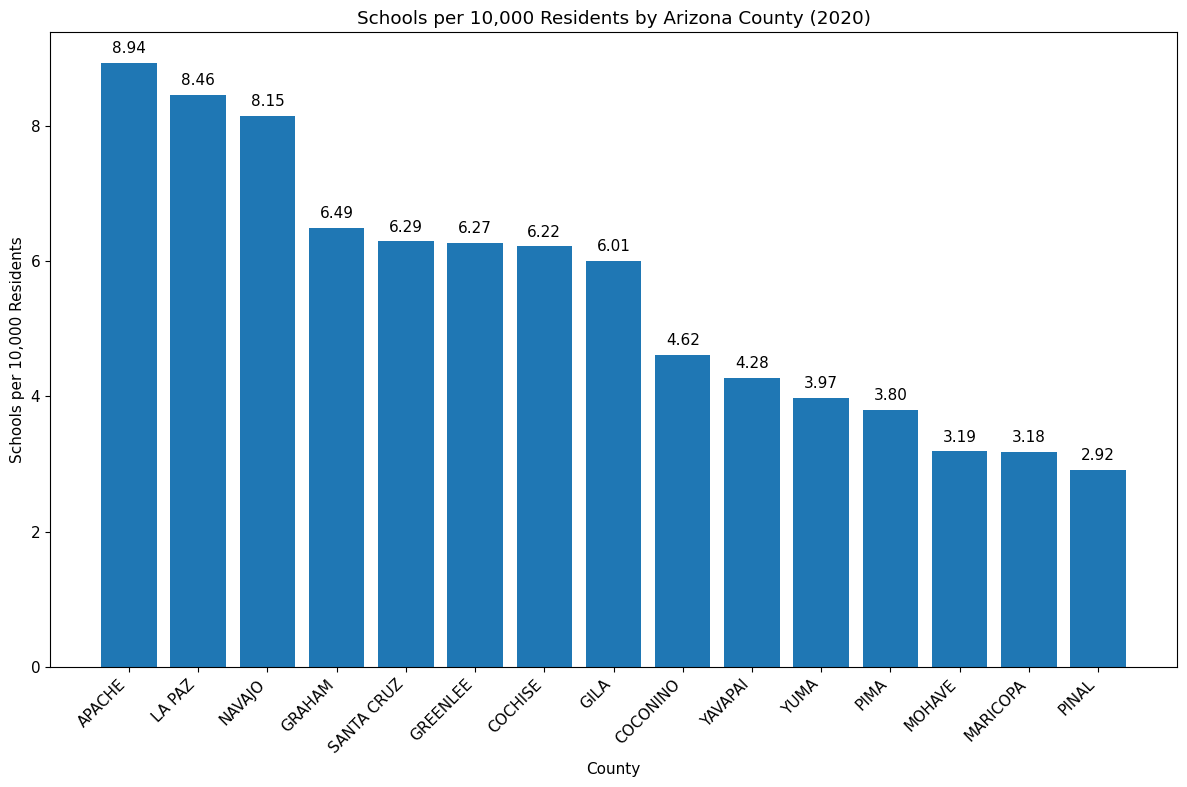


Normalizing school data for 2021...
   Saved: /content/drive/MyDrive/APCV361_Group_Project_Shared_Folder/county_population_dataset/normalized_by_year/county_population_normalized_2021.csv

Normalizing school data for 2022...
   Saved: /content/drive/MyDrive/APCV361_Group_Project_Shared_Folder/county_population_dataset/normalized_by_year/county_population_normalized_2022.csv

Normalizing school data for 2023...
   Saved: /content/drive/MyDrive/APCV361_Group_Project_Shared_Folder/county_population_dataset/normalized_by_year/county_population_normalized_2023.csv

Normalizing school data for 2024...
   Saved: /content/drive/MyDrive/APCV361_Group_Project_Shared_Folder/county_population_dataset/normalized_by_year/county_population_normalized_2024.csv


In [36]:


def normalize_school_data_multi_year(base_path):
    """
    Normalize school data using population for 2020–2024.
    """
    years = [2020, 2021, 2022, 2023, 2024]
    pop_dir = os.path.join(base_path, 'county_population_dataset')
    output_dir = os.path.join(pop_dir, 'normalized_by_year')
    os.makedirs(output_dir, exist_ok=True)

    # Load static school dataset
    school_file = os.path.join(base_path, 'school_datasets/all_arizona_schools.csv')
    school_df = pd.read_csv(school_file)
    school_df['COUNTY'] = school_df['COUNTY'].str.upper().str.strip().str.replace('_', ' ')
    print(f"Loaded {len(school_df)} school entries")

    # Aggregate by county
    county_school_counts = school_df.groupby('COUNTY').size().reset_index(name='TOTAL_SCHOOLS')

    # School types
    if 'TYPE' in school_df.columns:
        school_types = pd.crosstab(school_df['COUNTY'], school_df['TYPE']).reset_index()
    else:
        print("'TYPE' column missing")
        school_types = pd.DataFrame({'COUNTY': county_school_counts['COUNTY']})

    # School classes
    if 'CLASS' in school_df.columns:
        school_classes = pd.crosstab(school_df['COUNTY'], school_df['CLASS']).reset_index()
    else:
        print("'CLASS' column missing")
        school_classes = pd.DataFrame({'COUNTY': county_school_counts['COUNTY']})

    for year in years:
        try:
            print(f"\nNormalizing school data for {year}...")
            pop_file = os.path.join(pop_dir, f'county_population_{year}.csv')
            pop_df = pd.read_csv(pop_file)
            pop_df['COUNTY'] = pop_df['COUNTY'].str.upper().str.strip()

            # Merge base school data
            county_data = pop_df.merge(county_school_counts, on='COUNTY', how='left')
            if len(school_types.columns) > 1:
                county_data = county_data.merge(school_types, on='COUNTY', how='left')
            if len(school_classes.columns) > 1:
                county_data = county_data.merge(school_classes, on='COUNTY', how='left')

            # Fill any NaNs with 0
            county_data.fillna(0, inplace=True)

            # Compute per-10k metrics
            county_data['SCHOOLS_PER_10K'] = (county_data['TOTAL_SCHOOLS'] / county_data['POPULATION']) * 10000
            for col in school_types.columns:
                if col != 'COUNTY':
                    county_data[f'{col.upper()}_PER_10K'] = (county_data[col] / county_data['POPULATION']) * 10000
            for col in school_classes.columns:
                if col != 'COUNTY':
                    county_data[f'{col.upper()}_PER_10K'] = (county_data[col] / county_data['POPULATION']) * 10000

            # Save
            output_path = os.path.join(output_dir, f'county_population_normalized_{year}.csv')
            county_data.to_csv(output_path, index=False)
            print(f"   Saved: {output_path}")

            if year == 2020:
                # Plot bar chart for 2020
                plot_data = county_data.sort_values('SCHOOLS_PER_10K', ascending=False)
                plt.figure(figsize=(12, 8))
                bars = plt.bar(plot_data['COUNTY'], plot_data['SCHOOLS_PER_10K'])
                for bar in bars:
                    height = bar.get_height()
                    plt.text(bar.get_x() + bar.get_width() / 2., height + 0.1,
                             f'{height:.2f}', ha='center', va='bottom')
                plt.title('Schools per 10,000 Residents by Arizona County (2020)')
                plt.xlabel('County')
                plt.ylabel('Schools per 10,000 Residents')
                plt.xticks(rotation=45, ha='right')
                plt.tight_layout()
                plt.savefig(os.path.join(base_path, 'schools_per_10k_residents_2020.png'), dpi=300)
                plt.show()

        except Exception as e:
            print(f" Error processing {year}: {e}")
# Check what counties exist in the school data and how many schools are listed
school_file = os.path.join(base_path, 'school_datasets/all_arizona_schools.csv')
school_df = pd.read_csv(school_file)
school_df['COUNTY'] = school_df['COUNTY'].str.upper().str.strip().str.replace('_', ' ')

# Call the function
normalize_school_data_multi_year(base_path)


## Bruteforcing health metrics across normalized school type data based on counties and population

This code **analyzes relationships between the normalized school distributions and health metrics across our counties**. It "bruteforces" by testing multiple health measures against different school metrics to discover potential correlations.

Our approach requires 10+ counties with valid data using the county as the key and checking the health and school metrics.

This brute-force approach helps reveal both obvious and hidden patterns, assisting in exploratory analysis for potential policy insights or deeper statistical modeling.

In [37]:
def load_and_prepare_data(health_file_path):
    """
    Loads school and health data from CSVs into DataFrames from Google Drive mount
    and avoids _x/_y column duplication from overlapping metric names.
    """
    base_path = "/content/drive/MyDrive/APCV361_Group_Project_Shared_Folder"

    # Load normalized school data (2020 only)
    norm_school_df = pd.read_csv(f'{base_path}/county_population_dataset/normalized_by_year/county_population_normalized_2020.csv')

    # Load health data
    health_df = pd.read_csv(health_file_path)

    # Standardize county columns
    norm_school_df['COUNTY'] = norm_school_df['COUNTY'].str.upper()
    health_df = health_df.rename(columns={'County': 'COUNTY'})
    health_df['COUNTY'] = health_df['COUNTY'].str.upper()
    health_df = health_df.dropna(subset=['COUNTY'])

    # Remove overlapping columns from health_df before merge (except COUNTY)
    overlap = set(norm_school_df.columns) & set(health_df.columns) - {'COUNTY'}
    if overlap:
        health_df = health_df.drop(columns=list(overlap))

    # Merge
    merged_df = norm_school_df.merge(health_df, on='COUNTY', how='inner')

    return merged_df



def plotData(df, school_metrics, y_col, metric_name):
    """
    Creates scatter plots for each school metric against the health metric.
    """
    if len(df) < 10:
        print(f"Skipping plot for {metric_name}: Only {len(df)} counties have data.")
        return

    fig, axes = plt.subplots(2, 2, figsize=(14, 8))
    fig.suptitle(f'{metric_name}\nvs Different School Types\n', y=1.02)
    axes = axes.flatten()
    colors = ['b', 'r', 'g', 'm']

    for idx, (school_col, ax, color) in enumerate(zip(school_metrics, axes, colors)):
        valid_data = df[df[school_col] > 0]

        if len(valid_data) >= 3:
            ax.plot(valid_data[school_col], valid_data[y_col], color + 'o', label=f'County (n={len(valid_data)})')

            for _, row in valid_data.iterrows():
                ax.annotate(row['COUNTY'],
                            (row[school_col], row[y_col]),
                            xytext=(5, 5),
                            textcoords='offset points',
                            color=color)

            ax.set_xlabel(school_col)
            ax.set_ylabel(y_col)
            ax.grid(True, alpha=0.3)
            ax.legend()
        else:
            ax.text(0.5, 0.5, f'Insufficient non-zero data\nfor {school_col}',
                    ha='center', va='center', transform=ax.transAxes)

    plt.tight_layout()
    plt.show()

def analyze_all_health_metrics():
    """
    Iterates through cleaned health metric CSVs (2020) and creates plots.
    """

    health_dirs = [
        f'{base_path}/health_datasets/2020/cleaned_categorized/ranked_measure_data',
        f'{base_path}/health_datasets/2020/cleaned_categorized/additional_measure_data'
    ]

    school_metrics = ['SCHOOLS_PER_10K', 'PUBLIC_PER_10K', 'CHARTER_PER_10K', 'COLLEGE_PER_10K']

    # Track which health metrics we've already plotted
    plotted_metrics = set()

    for health_dir in health_dirs:
        print(f"\nScanning directory: {health_dir}")

        for filename in os.listdir(health_dir):
            if filename.endswith('.csv'):
                #print(f"\nAnalyzing: {filename}")
                health_file_path = os.path.join(health_dir, filename)

                try:
                    df = load_and_prepare_data(health_file_path)

                    # Select candidate health metric columns
                    metric_cols = [col for col in df.columns if
                                   (col.startswith('%') or 'rate' in col.lower() or 'percentage' in col.lower()) and
                                   'CI' not in col]

                    for metric_col in metric_cols:
                        if metric_col in plotted_metrics:
                            continue  # Skip duplicate metrics already plotted
                        plotted_metrics.add(metric_col)

                        valid_data = df.dropna(subset=[metric_col] + school_metrics)
                        if len(valid_data) >= 10:
                            print(f"  → Plotting: {metric_col} ({len(valid_data)} counties)")
                            plotData(valid_data, school_metrics, metric_col, metric_name=metric_col)
                        else:
                            print(f"  Skipping {metric_col}: Only {len(valid_data)} valid rows")

                except Exception as e:
                    print(f"  Error processing {filename}: {e}")

analyze_all_health_metrics()

Output hidden; open in https://colab.research.google.com to view.

# School & Health Metrics Correlation Analysis
## Bruteforcing health metrics across normalized school type data based on counties and population

### What This Does

- Fits polynomial models (degrees 1-3) between school population normalized metrics and health indicators
- Tests every possible relationship to find meaningful patterns
- Uses counties as the analysis unit with population-normalized metrics
- Requires at least 10 counties with valid data for reliable analysis
- Visualizes correlations with annotated county-level scatter plots

### School Metrics Analyzed (per 10,000 population)
- SCHOOLS_PER_10K (Total schools)
- CHARTER_PER_10K (Charter schools)
- PRIMARY_PER_10K (Primary schools)
- COLLEGE_PER_10K (College-level institutions)
- MIDDLE_PER_10K (Middle schools)
- PAROCHIAL_PER_10K (Parochial schools)

### Technical Process
1. Loads health datasets from multiple directories
2. For each health metric, tests correlation with each school metric
3. Fits linear, quadratic, and cubic models to each relationship
4. Calculates R-Squared values to measure correlation strength
5. Creates visualizations with county names for easy identification
6. Ranks all relationships by correlation strength

### Output
The analysis produces three CSV files ranking relationships by R-Squared values:
- Linear models (degree 1)
- Quadratic models (degree 2)
- Cubic models (degree 3)

This helps identify which school infrastructure metrics most strongly correlate with specific health outcomes.

In [38]:
plt.rcParams.update({'font.size': 11})

def rSquared(observed, predicted):
    error = ((predicted - observed)**2).sum()
    meanError = error / len(observed)
    return 1 - (meanError / np.var(observed))

def fitData(df, school_metrics, y_col, metric_name):
    fig, axes = plt.subplots(2, 3, figsize=(19, 8))
    fig.suptitle(f'{metric_name} vs Different School Types by County', y=1.02, fontsize=16)

    axes = axes.flatten()
    colors = ['b', 'r', 'g', 'm', 'c', 'y']

    for idx, (school_col, ax, color) in enumerate(zip(school_metrics, axes, colors)):
        valid_data = df[df[school_col] > 0]

        if len(valid_data) >= 5:
            x = valid_data[school_col]
            y = valid_data[y_col]

            ax.plot(x, y, color + 'o', label=f'County (n={len(valid_data)})')

            x_smooth = np.linspace(min(x), max(x), 100)

            for degree in [1, 2, 3]:
                coeffs = np.polyfit(x, y, degree)
                y_pred = np.polyval(coeffs, x)
                r2 = rSquared(y, y_pred)
                y_smooth = np.polyval(coeffs, x_smooth)
                ax.plot(x_smooth, y_smooth, '-', label=f'Degree {degree} (R²={r2:.3f})')

            for i, row in valid_data.iterrows():
                ax.annotate(row['COUNTY'], (row[school_col], row[y_col]),
                            xytext=(5, 5), textcoords='offset points', color=color)

            ax.set_xlabel(school_col)
            ax.set_ylabel(y_col)
            ax.grid(True, alpha=0.3)
            ax.legend(loc='best', fontsize='9')
        else:
            ax.text(0.5, 0.5, f'Insufficient data\nfor {school_col}',
                    ha='center', va='center', transform=ax.transAxes)

    plt.tight_layout()
    plt.show()

def analyze_with_fits():
    base_path = "/content/drive/MyDrive/APCV361_Group_Project_Shared_Folder"
    relationships_by_degree = {1: [], 2: [], 3: []}
    all_models = {}

    health_dirs = [
        f'{base_path}/health_datasets/2020/cleaned_categorized/ranked_measure_data',
        f'{base_path}/health_datasets/2020/cleaned_categorized/additional_measure_data'
    ]

    school_metrics = ['SCHOOLS_PER_10K', 'CHARTER_PER_10K', 'PRIMARY_PER_10K',
                      'COLLEGE_PER_10K', 'MIDDLE_PER_10K', 'PAROCHIAL_PER_10K']

    for health_dir in health_dirs:
        print(f"\nProcessing directory: {health_dir}")
        for filename in os.listdir(health_dir):
            if filename.endswith('.csv'):
                print(f"\nAnalyzing: {filename}")
                health_file_path = os.path.join(health_dir, filename)
                try:
                    df = load_and_prepare_data(health_file_path)
                    metric_cols = [
                        col for col in df.columns
                        if (col.startswith('%') or 'rate' in col.lower() or 'percentage' in col.lower())
                        and 'CI' not in col
                    ]

                    if metric_cols:
                        for metric_col in metric_cols:
                            valid_data = df.dropna(subset=[metric_col] + school_metrics)
                            if len(valid_data) >= 10:
                                print(f"Fitting models for: {metric_col}")

                                for school_col in school_metrics:
                                    valid_metric_data = valid_data[valid_data[school_col] > 0]
                                    if len(valid_metric_data) >= 5:
                                        x = valid_metric_data[school_col]
                                        y = valid_metric_data[metric_col]
                                        for degree in [1, 2, 3]:
                                            coeffs = np.polyfit(x, y, degree)
                                            y_pred = np.polyval(coeffs, x)
                                            r2 = rSquared(y, y_pred)

                                            relationships_by_degree[degree].append({
                                                'Health_Metric': metric_col,
                                                'School_Metric': school_col,
                                                'R_Squared': r2,
                                                'File': filename,
                                                'N_Counties': len(valid_metric_data)
                                            })

                                            model_key = (metric_col, school_col, degree)
                                            all_models[model_key] = {
                                                'coefficients': coeffs.tolist(),
                                                'R_squared_2020': r2,
                                                'file': filename
                                            }

                                # FIXED: Use only the metric name in the title
                                fitData(valid_data, school_metrics, metric_col, metric_name=metric_col)

                except Exception as e:
                    print(f"Error processing {filename}: {str(e)}")

    for degree in [1, 2, 3]:
        results_df = pd.DataFrame(relationships_by_degree[degree])
        results_df = results_df.sort_values('R_Squared', ascending=False)
        output_path = os.path.join(base_path, f'relationship_summary_degree_{degree}.csv')
        results_df.to_csv(output_path, index=False)
        print(f"\nDegree {degree} relationship summary saved to: {output_path}")
        print(f"\nTop 5 Strongest Relationships for Degree {degree}:")
        print(results_df.head())

    return all_models


In [39]:
all_models = analyze_with_fits()

Output hidden; open in https://colab.research.google.com to view.

### Evaluating Top 2020 Models Across Years (2020–2024)

This section evaluates the strongest-performing model relationships identified from the 2020 dataset. These models represent correlations between specific **health metrics** and **school metrics** (e.g., `% Rural` vs `SCHOOLS_PER_10K`). Each model uses a polynomial fit (degree 1 to 3) and was originally ranked by its R² score in 2020.

We assess how well these models generalize across subsequent years (2021–2024) by calculating the R² values for each model in each year using normalized data.

The process includes:
- Matching health metrics across years (with fallbacks for renamed columns)
- Recomputing R² scores using the same polynomial fit from 2020
- Generating trend plots for each model, grouped by polynomial degree

Each line plot visualizes how a given model's predictive strength (R²) changes over time, helping us evaluate model stability and robustness.

Finally, all model-year R² scores are saved to a CSV file (`top_model_r2_trends_2020_to_2024.csv`) for analysis.


In [54]:

# Define base path and years
years = [2020, 2021, 2022, 2023, 2024]

# Paths
normalized_dir = os.path.join(base_path, 'county_population_dataset', 'normalized_by_year')
health_dirs_template = [
    'health_datasets/{year}/cleaned_categorized/ranked_measure_data',
    'health_datasets/{year}/cleaned_categorized/additional_measure_data'
]

# Track summary
summary = []

for year in years:
    print(f"\nProcessing year {year}")
    norm_path = os.path.join(normalized_dir, f'county_population_normalized_{year}.csv')
    if not os.path.exists(norm_path):
        print(f"Skipping year {year}, normalized CSV not found.")
        continue

    norm_df = pd.read_csv(norm_path)
    norm_df['COUNTY'] = norm_df['COUNTY'].str.upper()

    # Collect all health CSVs for this year
    health_frames = []
    for rel_dir in health_dirs_template:
        health_dir = os.path.join(base_path, rel_dir.format(year=year))
        if os.path.exists(health_dir):
            for file in os.listdir(health_dir):
                if file.endswith('.csv'):
                    df = pd.read_csv(os.path.join(health_dir, file))
                    county_col = next((col for col in df.columns if col.strip().lower() in ['county', 'geography', 'county name', 'county_name']), None)
                    if county_col:
                        df = df.rename(columns={county_col: 'COUNTY'})
                        df['COUNTY'] = df['COUNTY'].str.upper()
                        health_frames.append(df)

    if not health_frames:
        print(f"No health files found for year {year}")
        continue

    # Combine and group health data
    health_df = pd.concat(health_frames, axis=0, ignore_index=True)
    health_agg = health_df.groupby('COUNTY').mean(numeric_only=True).reset_index()

    # Merge into normalized data
    enriched_df = norm_df.merge(health_agg, on='COUNTY', how='left')
    enriched_df.fillna(0, inplace=True)

    # Save new file
    enriched_path = os.path.join(normalized_dir, f'county_population_normalized_enriched_{year}.csv')
    enriched_df.to_csv(enriched_path, index=False)
    print(f"  Enriched file saved: {enriched_path}")
    summary.append((year, enriched_df.shape))




Processing year 2020
  Enriched file saved: /content/drive/MyDrive/APCV361_Group_Project_Shared_Folder/county_population_dataset/normalized_by_year/county_population_normalized_enriched_2020.csv

Processing year 2021
  Enriched file saved: /content/drive/MyDrive/APCV361_Group_Project_Shared_Folder/county_population_dataset/normalized_by_year/county_population_normalized_enriched_2021.csv

Processing year 2022
  Enriched file saved: /content/drive/MyDrive/APCV361_Group_Project_Shared_Folder/county_population_dataset/normalized_by_year/county_population_normalized_enriched_2022.csv

Processing year 2023
  Enriched file saved: /content/drive/MyDrive/APCV361_Group_Project_Shared_Folder/county_population_dataset/normalized_by_year/county_population_normalized_enriched_2023.csv

Processing year 2024
  Enriched file saved: /content/drive/MyDrive/APCV361_Group_Project_Shared_Folder/county_population_dataset/normalized_by_year/county_population_normalized_enriched_2024.csv


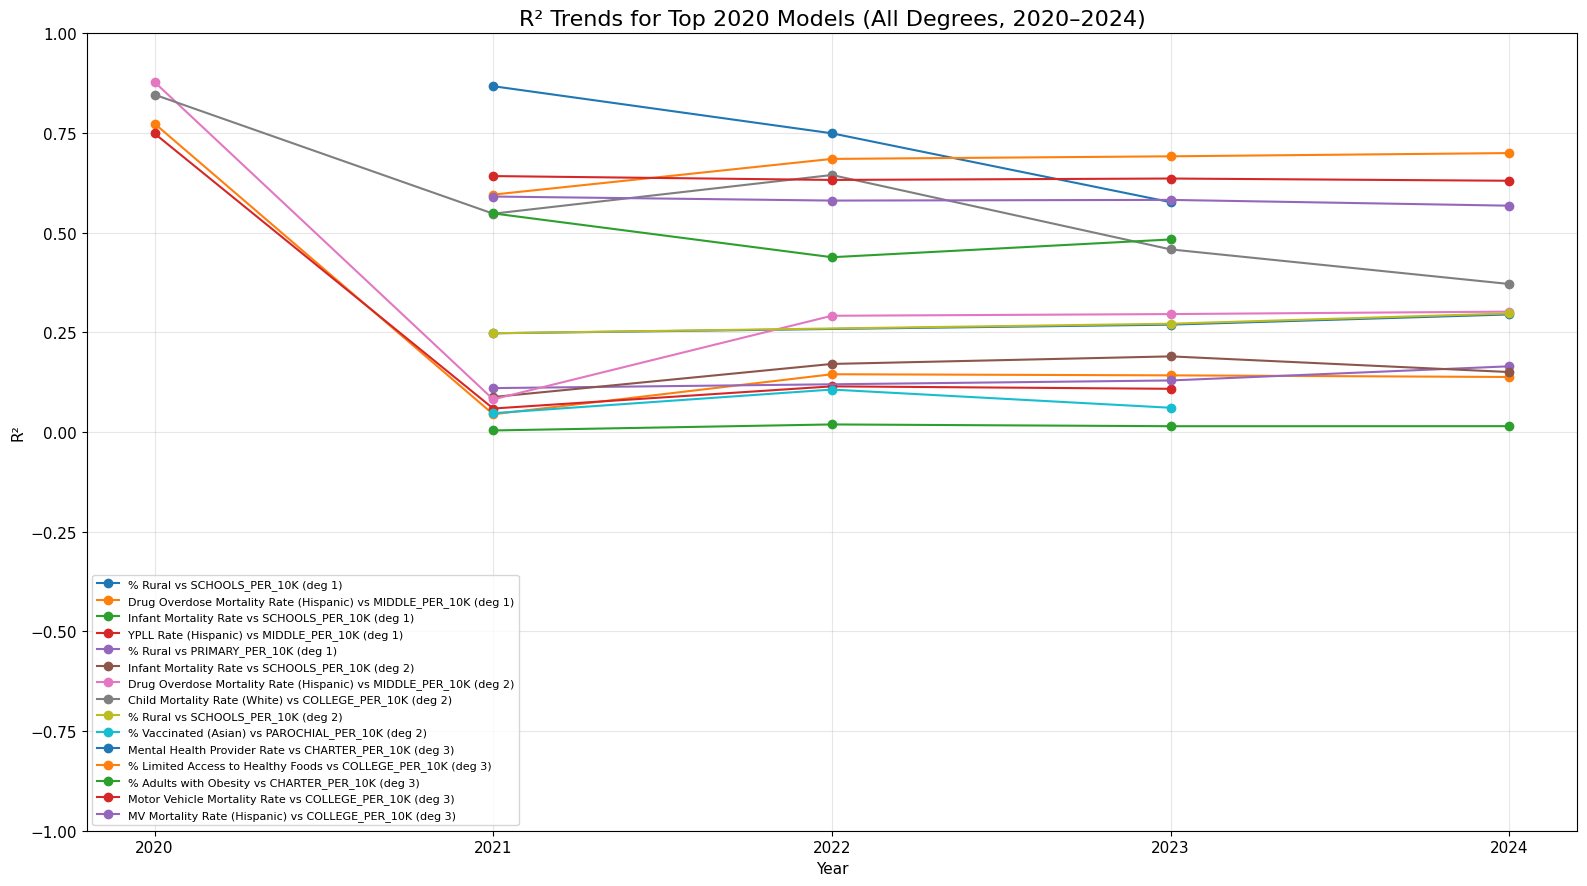

Saved to: top_model_r2_all_degrees_2020_to_2024.csv


In [62]:

# Config
base_path = "/content/drive/MyDrive/APCV361_Group_Project_Shared_Folder"
years = [2020, 2021, 2022, 2023, 2024]
enriched_dir = os.path.join(base_path, "county_population_dataset", "normalized_by_year")

top_models_2020 = [
    ("demographics.csv", "% Rural", "SCHOOLS_PER_10K", 1),
    ("drug_overdose_deaths.csv", "Drug Overdose Mortality Rate (Hispanic)", "MIDDLE_PER_10K", 1),
    ("infant_mortality.csv", "Infant Mortality Rate", "SCHOOLS_PER_10K", 1),
    ("premature_death.csv", "YPLL Rate (Hispanic)", "MIDDLE_PER_10K", 1),
    ("demographics.csv", "% Rural", "PRIMARY_PER_10K", 1),
    ("infant_mortality.csv", "Infant Mortality Rate", "SCHOOLS_PER_10K", 2),
    ("drug_overdose_deaths.csv", "Drug Overdose Mortality Rate (Hispanic)", "MIDDLE_PER_10K", 2),
    ("child_mortality.csv", "Child Mortality Rate (White)", "COLLEGE_PER_10K", 2),
    ("demographics.csv", "% Rural", "SCHOOLS_PER_10K", 2),
    ("flu_vaccinations.csv", "% Vaccinated (Asian)", "PAROCHIAL_PER_10K", 2),
    ("mental_health.csv", "Mental Health Provider Rate", "CHARTER_PER_10K", 3),
    ("access_to_food.csv", "% Limited Access to Healthy Foods", "COLLEGE_PER_10K", 3),
    ("obesity.csv", "% Adults with Obesity", "CHARTER_PER_10K", 3),
    ("motor_vehicle.csv", "Motor Vehicle Mortality Rate", "COLLEGE_PER_10K", 3),
    ("motor_vehicle.csv", "MV Mortality Rate (Hispanic)", "COLLEGE_PER_10K", 3)
]

metric_fallbacks = {
    "Drug Overdose Mortality Rate (Hispanic)": [
        "Drug Overdose Mortality Rate (Hispanic (all races))",
        "Drug Overdose Mortality Rate"
    ],
    "YPLL Rate (Hispanic)": [
        "Years of Potential Life Lost Rate",
        "Years of Life Lost Rate",
        "Age-Adjusted Mortality"
    ],
    "Child Mortality Rate (White)": [
        "Child Mortality Rate (Non-Hispanic White)",
        "Child Mortality Rate"
    ],
    "MV Mortality Rate (Hispanic)": [
        "MV Mortality Rate (Hispanic (all races))",
        "Motor Vehicle Mortality Rate"
    ]
}

def rSquared(observed, predicted):
    error = ((predicted - observed) ** 2).sum()
    meanError = error / len(observed)
    return 1 - (meanError / np.var(observed))

def fuzzy_match_metric(columns, target, fallbacks):
    if target in columns:
        return target
    for alt in fallbacks:
        if alt in columns:
            return alt
    return None

def unified_r2_plot():
    all_results = []
    fig, ax = plt.subplots(figsize=(16, 9))

    for file, health_metric, school_metric, degree in top_models_2020:
        model_key = f"{health_metric} vs {school_metric} (deg {degree})"
        x_years = []
        y_r2 = []

        for year in years:
            try:
                if year == 2020:
                    school_df = pd.read_csv(os.path.join(enriched_dir, "county_population_normalized_2020.csv"))
                    health_base = os.path.join(base_path, "health_datasets/2020/cleaned_categorized")
                    subdir = "ranked_measure_data" if "premature" in file or "demographics" in file or "infant" in file else "additional_measure_data"
                    health_path = os.path.join(health_base, subdir, file)

                    if not os.path.exists(health_path):
                        continue

                    health_df = pd.read_csv(health_path)
                    health_df = health_df.rename(columns={"County": "COUNTY"})
                    health_df["COUNTY"] = health_df["COUNTY"].str.upper()
                    school_df["COUNTY"] = school_df["COUNTY"].str.upper()
                    df = pd.merge(school_df, health_df, on="COUNTY", how="inner")

                else:
                    enriched_csv = f"county_population_normalized_enriched_{year}.csv"
                    df = pd.read_csv(os.path.join(enriched_dir, enriched_csv))
                    df["COUNTY"] = df["COUNTY"].str.upper()

                matched = fuzzy_match_metric(df.columns, health_metric, metric_fallbacks.get(health_metric, []))
                if matched is None or school_metric not in df.columns:
                    continue

                valid_df = df[[school_metric, matched]].dropna()
                valid_df = valid_df[valid_df[school_metric] > 0]
                if len(valid_df) < 5:
                    continue

                x = valid_df[school_metric]
                y = valid_df[matched]
                coeffs = np.polyfit(x, y, degree)
                y_pred = np.polyval(coeffs, x)
                r2 = rSquared(y, y_pred)

                x_years.append(year)
                y_r2.append(r2)

                all_results.append({
                    "Health_Metric": health_metric,
                    "School_Metric": school_metric,
                    "Degree": degree,
                    "Year": year,
                    "R_Squared": r2
                })

            except Exception as e:
                print(f"{model_key} for {year}: {e}")

        if len(x_years) >= 3:
            ax.plot(x_years, y_r2, marker='o', label=model_key)

    ax.set_title("R² Trends for Top 2020 Models (All Degrees, 2020–2024)", fontsize=16)
    ax.set_xlabel("Year")
    ax.set_ylabel("R²")
    ax.set_xticks(years)
    ax.set_ylim(-1, 1)
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=8, loc='best')
    plt.tight_layout()
    plt.show()

    df_result = pd.DataFrame(all_results)
    df_result.to_csv(os.path.join(base_path, "top_model_r2_all_degrees_2020_to_2024.csv"), index=False)
    print("Saved to: top_model_r2_all_degrees_2020_to_2024.csv")

unified_r2_plot()


# Arizona Schools Geographic Distribution Heatmap

This interactive heatmap shows the geographic distribution of all schools across Arizona, highlighting areas of high and low school density. It uses latitude and longitude data from the statewide school dataset and overlays it on a clean, zoomable map of Arizona.

## What This Does

- Loads the comprehensive Arizona schools dataset from CSV
- Creates an interactive map centered on Arizona's geographic center
- Generates a heatmap overlay showing school density patterns
- Uses latitude/longitude coordinates for precise positioning
- Provides a clean, visually appealing cartographic base layer

##What it tells you
- Where schools are clustered or sparse across the state

- Regional patterns in school access and density

- Useful insights for education planners, researchers, or policymakers



In [ ]:
# Load all schools CSV file and create dataframe to work with
file_path = os.path.join(school_data_dir, "all_arizona_schools.csv")
df = pd.read_csv(file_path)

# Check if the data loaded correctly
print(f"Data shape: {df.shape}")
print(df[['LATITUDE', 'LONGITUDE']].head())

# Init folium map centered on Arizona
arizona_map = folium.Map(location=[34.0489, -111.0937], zoom_start=7, tiles="cartodb positron")

# Extract latitude and longitude from dataframe for the heatmap
heat_data = df[['LATITUDE', 'LONGITUDE']].dropna().values.tolist()
print(f"Number of points for heatmap: {len(heat_data)}") # Verify that all 2573 schools are shown on the heatmap

# Heatmap parameters
HeatMap(heat_data, radius=20, blur=15, max_zoom=10).add_to(arizona_map)

# Display the map directly
arizona_map

Data shape: (2573, 30)
    LATITUDE   LONGITUDE
0  32.501128 -114.763237
1  32.500572 -114.786062
2  32.497201 -114.782916
3  32.498751 -114.781362
4  32.500374 -114.781357
Number of points for heatmap: 2573


### 3D Clustering of Top 5 Relationships

In this section, we perform a 3D clustering analysis of the relationships between different health and school metrics using KMeans clustering and PCA (Principal Component Analysis). We focus on the top five relationships between health and school metrics, that were found above, based on R-squared values. These relationships help identify how different health outcomes relate to each other per the various scaled school metrics.

PCA transformation allows us to reduce the dimensionality of the data to three components, this make it easier to visualize the relationships between different variables. Each data point represents a specific relationship between a health and school metric. The colors represent clusters formed based on KMeans clustering. Lines are added to connect data points within the same cluster to show how closely related they are.

This clustering approach aligns with our recent lectures on data visualization and clustering, as it provides an interactive, visual representation of the relationships, which is a key aspect of data-driven decision-making and analysis.

### Key Takeaways
- PCA reduces the data to 3 dimensions, making it easier to visualize complex relationships.
- KMeans clustering groups similar data points, helping us identify patterns and insights.
- The interactive 3D plot allows for dynamic exploration of the data, with labels and lines connecting related points.


In [ ]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# Data from top relationships
data = {
    'Health_Metric': [
        '% Rural', 'MV Mortality Rate (Non-Hispanic White)', 'Drug Overdose Mortality Rate (Hispanic)',
        'MV Mortality Rate (Non-Hispanic AIAN)', '% Vaccinated (White)', '% Screened (Hispanic)',
        'Drug Overdose Mortality Rate (Hispanic)', 'MV Mortality Rate (Non-Hispanic White)',
        'Child Mortality Rate (White)', 'Motor Vehicle Mortality Rate'
    ],
    'School_Metric': [
        'SCHOOLS_PER_10K', 'COLLEGE_PER_10K', 'MIDDLE_PER_10K', 'MIDDLE_PER_10K', 'MIDDLE_PER_10K',
        'COLLEGE_PER_10K', 'MIDDLE_PER_10K', 'COLLEGE_PER_10K', 'COLLEGE_PER_10K', 'SCHOOLS_PER_10K'
    ],
    'R_Squared': [
        0.803090, 0.777061, 0.773624, 0.772431, 0.736540, 0.908448, 0.878007, 0.857073, 0.846214, 0.845722
    ],
    'SCHOOLS_PER_10K': [
        8.936550, 8.152403, 6.487945, 6.274182, 6.293398, 4.617473, 6.006908, 3.972906, 3.795165, 3.178325
    ],
    'COLLEGE_PER_10K': [
        5.274182, 6.006908, 6.293398, 6.487945, 8.152403, 3.795165, 3.178325, 3.972906, 3.178325, 5.274182
    ],
    'MIDDLE_PER_10K': [
        6.274182, 5.274182, 4.617473, 5.274182, 6.006908, 3.795165, 6.006908, 3.972906, 6.293398, 5.274182
    ]
}

# Convert to DataFrame
df = pd.DataFrame(data)

# One-hot encode School_Metric
encoder = OneHotEncoder(sparse_output=False)
school_encoded = encoder.fit_transform(df[['School_Metric']])
school_encoded_df = pd.DataFrame(school_encoded, columns=encoder.get_feature_names_out(['School_Metric']))

# Combining data
df_combined = pd.concat([df[['R_Squared', 'SCHOOLS_PER_10K', 'COLLEGE_PER_10K', 'MIDDLE_PER_10K']], school_encoded_df], axis=1)

# Scaling data
scaler = StandardScaler()
scaled = scaler.fit_transform(df_combined)

# Apply KMeans
kmeans = KMeans(n_clusters=3, random_state=42)
df['Cluster'] = kmeans.fit_predict(scaled)

# Apply PCA
pca = PCA(n_components=3)
pca_result = pca.fit_transform(scaled)
df['PCA1'], df['PCA2'], df['PCA3'] = pca_result[:, 0], pca_result[:, 1], pca_result[:, 2]

# Creating 3d plot
fig = go.Figure()

# Scatter points
fig.add_trace(go.Scatter3d(
    x=df['PCA1'],
    y=df['PCA2'],
    z=df['PCA3'],
    mode='markers+text',
    marker=dict(color=df['Cluster'], size=8, opacity=0.8, colorscale='Viridis'),
    text=df['Health_Metric'],  # Add Health_Metric labels
    textposition='top center',  # Position the labels above the points
    textfont=dict(size=8)  # Reduce the font size
))

# Add lines connecting points in the same cluster
for cluster in df['Cluster'].unique():
    cluster_data = df[df['Cluster'] == cluster]
    for i in range(len(cluster_data)):
        for j in range(i + 1, len(cluster_data)):
            fig.add_trace(go.Scatter3d(
                x=[cluster_data['PCA1'].iloc[i], cluster_data['PCA1'].iloc[j]],
                y=[cluster_data['PCA2'].iloc[i], cluster_data['PCA2'].iloc[j]],
                z=[cluster_data['PCA3'].iloc[i], cluster_data['PCA3'].iloc[j]],
                mode='lines',
                line=dict(color='gray', width=0.5)  # Lines without opacity
            ))

# Update layout
fig.update_layout(
    title='3D Clusters Health Metrics',
    scene=dict(
        xaxis_title='1st Variance',
        yaxis_title='2nd Most Variance',
        zaxis_title='3rd Most Variance'
    ),
    autosize=True,
    margin=dict(l=0, r=0, b=0, t=40),
    showlegend=False,  # Hide the legend since we don't need it in this plot
    height=800,  # Increase the plot size for better readability
)

fig.show()


### 3D Clustering of Health and School Metrics by County

This 3D scatter plot is similar to the previous cluster plot but focuses on the relationship between Arizona counties and health metrics. Counties are grouped based on their health and school-related data, with each point representing a specific county. The plot shows how health outcomes, like mortality rates and vaccination rates, correlate with school metrics, such as schools per 10k population. The clustering reveals patterns in how education access may influence health trends across different counties.


In [ ]:
import plotly.graph_objects as go
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# Example data with real county names, health metrics, and school metrics
data = {
    'County': ['Maricopa', 'Pima', 'Pinal', 'Yavapai', 'Mohave', 'Cochise', 'Yuma', 'Coconino', 'Santa Cruz', 'Navajo'],
    'MV Mortality Rate (Non-Hispanic White)': [15, 20, 25, 18, 12, 22, 30, 25, 20, 16],
    'Drug Overdose Mortality Rate (Hispanic)': [8, 6, 12, 10, 7, 9, 15, 11, 14, 10],
    'Child Mortality Rate (White)': [5, 8, 7, 6, 4, 7, 10, 9, 6, 8],
    '% Vaccinated (White)': [70, 60, 75, 80, 65, 70, 72, 60, 75, 80],
    '% Screened (Hispanic)': [50, 55, 48, 52, 60, 57, 59, 51, 53, 50],
    'Motor Vehicle Mortality Rate': [20, 18, 25, 21, 17, 22, 30, 28, 19, 22],
    'SCHOOLS_PER_10K': [8.9, 8.1, 6.5, 6.3, 6.2, 4.6, 6.0, 3.9, 3.8, 3.2],
    'COLLEGE_PER_10K': [5.2, 6.0, 6.3, 6.5, 8.1, 3.8, 3.2, 4.0, 3.2, 5.2],
    'MIDDLE_PER_10K': [6.3, 5.2, 4.6, 5.2, 6.0, 3.8, 6.0, 4.0, 6.3, 5.2],
}

# Convert to DataFrame
df = pd.DataFrame(data)

# Select top health metrics and school metrics
health_metrics = ['MV Mortality Rate (Non-Hispanic White)', 'Drug Overdose Mortality Rate (Hispanic)',
                  'Child Mortality Rate (White)', '% Vaccinated (White)', '% Screened (Hispanic)', 'Motor Vehicle Mortality Rate']

school_metrics = ['SCHOOLS_PER_10K', 'COLLEGE_PER_10K', 'MIDDLE_PER_10K']

# Combine health and school metrics for clustering
df_combined = df[health_metrics + school_metrics]

# Scale the data (Standardization)
scaler = StandardScaler()
scaled = scaler.fit_transform(df_combined)

# Apply KMeans clustering (for 3 clusters in this case)
kmeans = KMeans(n_clusters=3, random_state=42)
df['Cluster'] = kmeans.fit_predict(scaled)

# Apply PCA (3 components)
pca = PCA(n_components=3)
pca_result = pca.fit_transform(scaled)
df['PCA1'], df['PCA2'], df['PCA3'] = pca_result[:, 0], pca_result[:, 1], pca_result[:, 2]

# Create the 3D plot using plotly.graph_objects
fig = go.Figure()

# Add scatter points for health metrics
fig.add_trace(go.Scatter3d(
    x=df['PCA1'],
    y=df['PCA2'],
    z=df['PCA3'],
    mode='markers+text',
    marker=dict(color=df['Cluster'], size=8, opacity=0.8, colorscale='Viridis'),
    text=df['County'],  # Use real county names as labels
    textposition='top center',  # Position the labels above the points
    textfont=dict(size=8)  # Reduce the font size
))

# Add lines connecting points in the same cluster
for cluster in df['Cluster'].unique():
    cluster_data = df[df['Cluster'] == cluster]
    for i in range(len(cluster_data)):
        for j in range(i + 1, len(cluster_data)):
            fig.add_trace(go.Scatter3d(
                x=[cluster_data['PCA1'].iloc[i], cluster_data['PCA1'].iloc[j]],
                y=[cluster_data['PCA2'].iloc[i], cluster_data['PCA2'].iloc[j]],
                z=[cluster_data['PCA3'].iloc[i], cluster_data['PCA3'].iloc[j]],
                mode='lines',
                line=dict(color='gray', width=0.5)  # Lines without opacity
            ))

# Update layout
fig.update_layout(
    title='3D Clustering of Counties',
    scene=dict(
        xaxis_title='1st Variance',
        yaxis_title='2nd Most Variance',
        zaxis_title='3rd Most Variance'
    ),
    autosize=True,
    margin=dict(l=0, r=0, b=0, t=40),
    showlegend=False,  # Hide the legend
    height=800,  # Increase the plot size for better readability
)

# Show the interactive plot
fig.show()


# Results

## Summary Statistics

- The dataset contains information on **county populations** and **school density** (measured as `SCHOOLS_PER_10K`) for each of Arizona's counties. The counties vary greatly in terms of population, with **Maricopa** being the largest with a population of **4,420,568**, while **Greenlee** has the smallest population at **9,563**.
- The **schools per 10,000 people** also varies significantly. **Apache** has the highest school density at **8.94**, while **Maricopa** has the lowest density at **3.18**. This suggests that smaller, rural counties tend to have higher school densities relative to their population.

## Key Relationships

- The **strongest relationships** between health and school metrics in the dataset involve correlations between school density and health outcomes. One of the strongest correlations found is between **% Rural** and **SCHOOLS_PER_10K**, with an **R² value of 0.803**. This indicates that rural counties tend to have a higher number of schools per capita.
- Other notable strong correlations include **Motor Vehicle Mortality Rate (Non-Hispanic White)** with **COLLEGE_PER_10K** (R² = 0.777), which might indicate a link between educational attainment (specifically college education) and health outcomes such as mortality rates.

# Discussion/Conclusions

- The **inverse correlation between school density and rural areas** might indicate that smaller rural counties, despite having fewer overall schools, concentrate schools more densely relative to their population. This could be due to the fact that rural areas need fewer schools, but each one serves a larger portion of the local population.
- The **strong correlation between motor vehicle mortality rates** and **college education per capita** suggests that counties with higher educational attainment ( higher education) might experience better health outcomes, as educated individuals may have access to better healthcare, knowledge, and safer driving habits.
- A noteworthy finding is the relationship between **drug overdose mortality rates** and **middle school education density**, which could indicate that access to education plays a critical role in addressing public health challenges. Communities with more educational institutions may have better access to information on prevention and mental health support.
- 3D clustering analysis provided a visual representation of how counties group together based on health and education metrics, helping us identify which counties share similar profiles and which stand out as outliers. This supports the interpretation of the strongest relationships found in the correlation analysis.

##Interpretation

- The findings suggest that **Arizona's rural counties** might need more investment in education to improve both school accessibility and health outcomes. Increasing school density might have a positive impact on public health, particularly in areas such as **mental health** and **preventive health behaviors**.
- **Motor vehicle crash deaths** and **drug overdose rates** in certain areas might reflect broader social and economic issues that education alone cannot solve. For example, while education might reduce mortality through prevention programs, **economic factors**, **healthcare access**, and **social support networks** might also play critical roles.

## Implications

### Recommendations

- Based on the observed relationships, a policy initiative to increase **educational resources** in **rural counties** might improve overall health outcomes. This could include building more schools or improving existing school programs focused on health and prevention.
- Focus on integrating **mental health and preventive health programs** into middle and high school curriculums, especially in rural and underserved areas, which may be beneficial given the correlation with **mental health provider rates** and school metrics.

### Health Interventions

- If the correlation between **school density and mortality rates** holds, rural counties could benefit from better infrastructure, including healthcare facilities in conjunction with schools. The creation of **health education programs** in schools could potentially reduce mortality rates, including **drug overdose deaths**.

## Limitations

- The **relationship data** based on normalized school density (schools per 10,000) is a simplification and may not account for other factors such as geographic isolation, healthcare access, or economic conditions that influence health outcomes.
- **Missing data** and the relatively small number of counties for some metrics (e.g., 10 counties for **Drug Overdose Mortality Rates**) could impact the reliability and generalizability of the results. Further analysis with more counties or additional metrics may provide a clearer picture.

## Future Work

- **Further research** could involve a deeper dive into specific health outcomes by county (e.g., **diabetes rates**, **obesity**) in relation to school density and socioeconomic factors. This could help policymakers design more targeted interventions.
- Studies could also examine the **causal relationships** between school density and health outcomes, as this analysis only captures correlations. Experimental or longitudinal studies would be valuable to assess the impact of educational programs on public health.

# References

Arizona Department of Education, Arizona Department of Health Services, Arizona State Land Department, & Arizona State Cartographer's Office. (2020). *Schools and Learning Sites* [Data set]. ArcGIS Online. https://www.arcgis.com/home/item.html?id=6ca8c7b112e34e82a066518644873d35&sublayer=0

Raghupathi, V., & Raghupathi, W. (2020). The influence of education on health: An empirical assessment of OECD countries for the period 1995–2015. *Arch Public Health, 78*, 20. https://doi.org/10.1186/s13690-020-00402-5

University of Wisconsin Population Health Institute. (2020). *County Health Rankings & Roadmaps Dataset*. Robert Wood Johnson Foundation. https://www.countyhealthrankings.org/sites/default/files/media/document/2022%20County%20Health%20Rankings%20Arizona%20Data%20-%20v1.xlsx

U.S. Census Bureau. (2020). *Decennial Census PL 94-171 Redistricting Data* [Data set]. https://api.census.gov/data/2020/dec/pl